In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # Gold v1 — Features e Análises (IBOV, SP500, DXY)
# MAGIC
# MAGIC ## Objetivos
# MAGIC A partir das tabelas Silver, construir uma camada Gold orientada a análise quantitativa:
# MAGIC - Features técnicas do IBOV (retornos, médias, Bollinger, ATR, label)
# MAGIC - Retornos diários (IBOV, SP500, DXY) em base alinhada
# MAGIC - Correlação global (Pearson) e correlação dinâmica (rolling)
# MAGIC - Tabela analítica unificada para exploração e modelagem
# MAGIC
# MAGIC ## Entradas (Silver)
# MAGIC - `mvp_finance.silver_prices_long`
# MAGIC - `mvp_finance.silver_prices_wide_aligned` (preferencial)
# MAGIC - `mvp_finance.silver_returns_wide` (preferencial)
# MAGIC
# MAGIC ## Saídas (Gold)
# MAGIC - `mvp_finance.gold_ibov_features`
# MAGIC - `mvp_finance.gold_retornos_global`
# MAGIC - `mvp_finance.gold_corr_ibov_global`
# MAGIC - `mvp_finance.gold_analytics_ibov_global`


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 0) Imports e contexto
# COMMAND ----------
import pyspark.sql.functions as F
from pyspark.sql.window import Window

spark.sql("USE mvp_finance")


DataFrame[]

In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 1) Leitura das tabelas Silver
# MAGIC Carregamos as tabelas e validamos rapidamente schemas/amostras.
# MAGIC
# MAGIC Observação:
# MAGIC - `wide_aligned` + `returns_wide` são preferíveis para evitar gaps e “matriz quebrada”.
# COMMAND ----------
silver_long   = spark.table("silver_prices_long")
silver_wide_a = spark.table("silver_prices_wide_aligned")
silver_ret    = spark.table("silver_returns_wide")

print("Schema silver_prices_long:")
silver_long.printSchema()

print("Schema silver_prices_wide_aligned:")
silver_wide_a.printSchema()

print("Schema silver_returns_wide:")
silver_ret.printSchema()

display(silver_long.limit(5))
display(silver_wide_a.limit(5))
display(silver_ret.limit(5))


Schema silver_prices_long:
root
 |-- timestamp: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- source: string (nullable = true)
 |-- ingestion_ts: timestamp (nullable = true)

Schema silver_prices_wide_aligned:
root
 |-- trade_date: date (nullable = true)
 |-- BITCOIN: double (nullable = true)
 |-- DOWJONES: double (nullable = true)
 |-- dxy_close: double (nullable = true)
 |-- MEXICO: double (nullable = true)
 |-- NASDAQ: double (nullable = true)
 |-- PETROLEO: double (nullable = true)
 |-- sp500_close: double (nullable = true)
 |-- TREASURY10Y: double (nullable = true)
 |-- BITCOIN_prev: double (nullable = true)
 |-- DOWJONES_prev: double (nullable = true)
 |-- dxy_close_prev: double (nullable = true)
 |-- MEXICO_prev: double (nullable = true)
 |--

timestamp date open high low close volume symbol source ingestion_ts 2023-12-19T00:00:00.000Z 2023-12-19 57737.41 58338.32 57374.39 57694.34 2.189417E8 MEXICO yahoo_finance_api 2025-12-22T01:41:04.217Z 2023-12-19T00:00:00.000Z 2023-12-19 3.9 3.93 3.9 3.92 0.0 TREASURY10Y yahoo_finance_api 2025-12-22T01:41:04.217Z 2023-12-20T00:00:00.000Z 2023-12-20 37520.13 37641.3 37073.04 37082.0 3.0345E8 DOWJONES yahoo_finance_api 2025-12-22T01:41:04.217Z 2023-12-20T00:00:00.000Z 2023-12-20 57689.35 57826.89 56811.44 56909.37 2.062199E8 MEXICO yahoo_finance_api 2025-12-22T01:41:04.217Z 2023-12-20T00:00:00.000Z 2023-12-20 14973.36 15069.29 14776.29 14777.94 6.2947E9 NASDAQ yahoo_finance_api 2025-12-22T01:41:04.217Z

trade_date BITCOIN DOWJONES dxy_close MEXICO NASDAQ PETROLEO sp500_close TREASURY10Y BITCOIN_prev DOWJONES_prev dxy_close_prev MEXICO_prev NASDAQ_prev PETROLEO_prev sp500_close_prev TREASURY10Y_prev 2023-12-19 null null null 57694.34 null null null 3.92 null null null null null null null null 2023-12-20 null 37082.0 null 56909.37 14777.94 null 4698.35 3.88 null null null 57694.34 null null null 3.92 2023-12-21 null 37404.35 101.84 57487.7 14963.87 73.89 4746.75 3.89 null 37082.0 null 56909.37 14777.94 null 4698.35 3.88 2023-12-22 43997.9 37385.97 101.7 57313.47 14992.97 73.56 4754.63 3.9 null 37404.35 101.84 57487.7 14963.87 73.89 4746.75 3.89 2023-12-23 43739.54 null 101.7 null null null 4754.63 null 43997.9 37385.97 101.7 57313.47 14992.97 73.56 4754.63 3.9

trade_date BITCOIN DOWJONES dxy_close MEXICO NASDAQ PETROLEO sp500_close TREASURY10Y BITCOIN_prev DOWJONES_prev dxy_close_prev MEXICO_prev NASDAQ_prev PETROLEO_prev sp500_close_prev TREASURY10Y_prev BITCOIN_ret DOWJONES_ret dxy_close_ret MEXICO_ret NASDAQ_ret PETROLEO_ret sp500_close_ret TREASURY10Y_ret 2023-12-19 null null null 57694.34 null null null 3.92 null null null null null null null null null null null null null null null null 2023-12-20 null 37082.0 null 56909.37 14777.94 null 4698.35 3.88 null null null 57694.34 null null null 3.92 null null null -0.013605667384356868 null null null -0.010204081632653073 2023-12-21 null 37404.35 101.84 57487.7 14963.87 73.89 4746.75 3.89 null 37082.0 null 56909.37 14777.94 null 4698.35 3.88 null 0.008692896823256469 null 0.010162298405341552 0.01258159120960034 null 0.01030148882054327 0.002577319587628857 2023-12-22 43997.9 37385.97 101.7 57313.47 14992.97 73.56 4754.63 3.9 null 37404.35 101.84 57487.7 14963.87 73.89 4746.75 3.89 null -4.913866970017722E-4 -0.001374705420267075 -0.003030735270327267 0.001944684095758653 -0.004466098254161555 0.0016600832148312428 0.0025706940874035134 2023-12-23 43739.54 null 101.7 null null null 4754.63 null 43997.9 37385.97 101.7 57313.47 14992.97 73.56 4754.63 3.9 -0.005872098441061957 null 0.0 null null null 0.0 null

In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 2) GOLD — Features técnicas Multi-Ativo (`gold_asset_features`)
# MAGIC
# MAGIC **Base:** `silver_prices_long` (todos os símbolos disponíveis)
# MAGIC
# MAGIC **Features (por símbolo):**
# MAGIC - `close_prev`, `retorno`, `retorno_log`
# MAGIC - `sma20`, `sma50`
# MAGIC - `boll_upper`, `boll_lower` (20 períodos, 2 desvios)
# MAGIC - `true_range`, `atr14` (ATR clássico via TR rolling)
# MAGIC - `label_direcao` (1 se retorno > 0, senão 0)
# MAGIC
# MAGIC **Observação de rigor:**
# MAGIC ATR usa:
# MAGIC `TR = max(high-low, |high-close_prev|, |low-close_prev|)`

# COMMAND ----------
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Janela por ativo (símbolo)
w_sym = Window.partitionBy("symbol").orderBy("timestamp")

features_df = (
    silver_long
    .orderBy("symbol", "timestamp")
    .withColumn("close_prev", F.lag("close", 1).over(w_sym))
    .withColumn("retorno", (F.col("close") / F.col("close_prev")) - F.lit(1))
    .withColumn("retorno_log", F.log(F.col("close") / F.col("close_prev")))
    .withColumn("sma20", F.avg("close").over(w_sym.rowsBetween(-19, 0)))
    .withColumn("sma50", F.avg("close").over(w_sym.rowsBetween(-49, 0)))
    .withColumn("std20", F.stddev("close").over(w_sym.rowsBetween(-19, 0)))
    .withColumn("boll_upper", F.col("sma20") + F.lit(2) * F.col("std20"))
    .withColumn("boll_lower", F.col("sma20") - F.lit(2) * F.col("std20"))
)

tr = F.greatest(
    (F.col("high") - F.col("low")),
    F.abs(F.col("high") - F.lag("close", 1).over(w_sym)),
    F.abs(F.col("low")  - F.lag("close", 1).over(w_sym)),
)

features_df = (
    features_df
    .withColumn("true_range", tr)
    .withColumn("atr14", F.avg("true_range").over(w_sym.rowsBetween(-13, 0)))
    .withColumn("label_direcao", F.when(F.col("retorno") > 0, F.lit(1)).otherwise(F.lit(0)))
)

display(features_df.select(
    "symbol","timestamp","date","open","high","low","close","volume",
    "retorno","retorno_log","sma20","sma50","boll_upper","boll_lower","atr14","label_direcao"
).orderBy("symbol","timestamp").limit(20))





symbol timestamp date open high low close volume retorno retorno_log sma20 sma50 boll_upper boll_lower atr14 label_direcao BITCOIN 2023-12-22T00:00:00.000Z 2023-12-22 43868.99 44367.96 43441.97 43997.9 2.1028503216E10 null null 43997.9 43997.9 null null 925.989999999998 0 BITCOIN 2023-12-23T00:00:00.000Z 2023-12-23 44012.2 44015.7 43351.36 43739.54 1.3507796558E10 -0.005872098441061957 -0.005889407002759387 43868.72 43868.72 44234.096215974714 43503.34378402529 795.1649999999972 0 BITCOIN 2023-12-24T00:00:00.000Z 2023-12-24 43728.37 43945.52 42786.92 43016.12 1.8830554085E10 -0.016539268588558476 -0.01667756934064452 43584.52 43584.52 44602.35376324427 42566.686236755726 916.3099999999977 0 BITCOIN 2023-12-25T00:00:00.000Z 2023-12-25 43010.57 43765.09 42765.77 43613.14 2.111579537E10 0.013878983041706094 0.013783551933961542 43591.675 43591.675 44423.22544994276 42760.12455005725 937.0624999999982 1 BITCOIN 2023-12-26T00:00:00.000Z 2023-12-26 43599.85 43603.18 41676.49 42520.4 3.0026850982E10 -0.025055292969045517 -0.02537452032988713 43377.42 43377.42 44576.048889022786 42178.79111097721 1136.9799999999989 0 BITCOIN 2023-12-27T00:00:00.000Z 2023-12-27 42518.47 43683.16 42167.58 43442.86 2.5260941032E10 0.021694527803125085 0.021462550628621138 43388.32666666667 43388.32666666667 44461.74359402838 42314.90973930495 1200.0799999999992 1 BITCOIN 2023-12-28T00:00:00.000Z 2023-12-28 43468.2 43804.78 42318.55 42627.86 2.2992093014E10 -0.01876027499110322 -0.018938481268856444 43279.688571428575 43279.688571428575 44415.75599192958 42143.62115092757 1240.9585714285702 0 BITCOIN 2023-12-29T00:00:00.000Z 2023-12-29 42614.64 43124.32 41424.06 42099.4 2.6000021055E10 -0.01239705676053171 -0.012474541321681076 43132.152500000004 43132.152500000004 44474.84058179712 41789.464418202886 1298.3712499999992 0 BITCOIN 2023-12-30T00:00:00.000Z 2023-12-30 42091.75 42584.13 41556.23 42156.9 1.6013925945E10 0.001365815189765085 0.0013648833126169253 43023.79111111112 43023.79111111112 44438.067864806966 41609.51435741527 1268.3188888888876 1 BITCOIN 2023-12-31T00:00:00.000Z 2023-12-31 42152.1 42860.94 41998.25 42265.19 1.639749881E10 0.0025687372648368623 0.002565443698268069 42947.931000000004 42947.931000000004 44365.01494690413 41530.84705309588 1227.755999999999 1 BITCOIN 2024-01-01T00:00:00.000Z 2024-01-01 42280.23 44175.44 42214.98 44167.33 1.8426978443E10 0.04500488463437646 0.044021559697119204 43058.78545454546 43058.78545454546 44591.10965829254 41526.461250798384 1294.3654545454535 1 BITCOIN 2024-01-02T00:00:00.000Z 2024-01-02 44187.14 45899.71 44176.95 44957.97 3.9335274536E10 0.017901014165900397 0.017742677807226142 43217.05083333334 43217.05083333334 45043.758795233574 41390.34287143311 1330.8666666666657 1 BITCOIN 2024-01-03T00:00:00.000Z 2024-01-03 44961.6 45503.24 40813.54 42848.18 4.6342323118E10 -0.046928053023746474 -0.04806488292440649 43188.676153846165 43188.676153846165 44949.5442673731 41427.80804031923 1589.2384615384603 0 BITCOIN 2024-01-04T00:00:00.000Z 2024-01-04 42855.82 44770.02 42675.18 44179.92 3.044809121E10 0.031080433287948184 0.03060721682009618 43259.4792857143 43259.4792857143 45032.29544898871 41486.66312243988 1625.3528571428558 1 BITCOIN 2024-01-05T00:00:00.000Z 2024-01-05 44192.98 44353.29 42784.72 44162.69 3.2336029347E10 -3.899961792596107E-4 -3.9007224754773333E-4 43319.69333333334 43319.69333333334 45090.54900664363 41548.837660023055 1671.2514285714274 0 BITCOIN 2024-01-06T00:00:00.000Z 2024-01-06 44178.95 44227.63 43475.16 43989.2 1.6092503468E10 -0.00392842917856695 -0.003936165724768655 43361.537500000006 43361.537500000006 45104.7895248547 41618.28547514531 1677.5464285714272 0 BITCOIN 2024-01-07T00:00:00.000Z 2024-01-07 43998.46 44495.57 43662.23 43943.1 1.9330573863E10 -0.0010479845052876469 -0.001048534025008291 43395.74705882353 43395.74705882353 45107.05493059536 41684.4391870517 1654.3135714285697 0 BITCOIN 2024-01-08T00:00:00.000Z 2024-01-08 43948.71 47218.0 43244.08 46970.5 4.2746192015E

## Análise Exploratória das Features — Exemplo com Bitcoin

Nesta seção realizamos uma **análise exploratória (EDA)** das features calculadas na camada **Gold**, com o objetivo de **validar visualmente** se os indicadores técnicos construídos fazem sentido do ponto de vista financeiro e estatístico.

### Por que escolhemos o Bitcoin?

O **Bitcoin foi escolhido de forma intencionalmente aleatória**, apenas como **ativo representativo** para demonstração visual.  
Os mesmos cálculos e gráficos **podem ser aplicados a qualquer outro ativo** presente no dataset (`NASDAQ`, `DOWJONES`, `PETROLEO`, `TREASURY10Y`, etc.), pois todas as features foram construídas de forma **genérica e multi-ativo**.

O uso do Bitcoin facilita a interpretação visual por apresentar:
- Alta volatilidade
- Regimes claros de tendência
- Movimentos amplos que tornam indicadores técnicos mais evidentes

##  Preço + Médias Móveis + Bandas de Bollinger

**Objetivo:** 

Validar se as médias móveis (`SMA20`, `SMA50`) e as Bandas de Bollinger capturam corretamente:
- Tendência
- Consolidação
- Regiões de sobrecompra e sobrevenda

**Interpretação esperada:**
- Preço acima da SMA20/SMA50 indica tendência de alta
- Toques ou rompimentos das bandas sugerem extremos de preço
- Estreitamento das bandas indica redução de volatilidade

Este gráfico confirma que as bandas e médias acompanham o comportamento do preço de forma coerente.

## ATR14 — Volatilidade

**Objetivo:** 

Analisar se o indicador de volatilidade (`ATR14`) reage adequadamente a períodos de estresse e calmaria do mercado.

**Interpretação esperada:**
- Picos de ATR coincidem com movimentos bruscos do preço
- ATR reduzido indica períodos de consolidação
- ATR serve como base para gestão de risco e dimensionamento de posição

O gráfico mostra claramente a alternância entre regimes de baixa e alta volatilidade.

## Retornos Diários

**Objetivo:**  

Verificar a sanidade estatística dos retornos:
- Presença de outliers
- Simetria em torno de zero
- Estabilidade ao longo do tempo

**Interpretação esperada:**
- Retornos oscilam em torno de zero
- Não há explosões artificiais (sanity check)
- Confirma que o cálculo de retorno está correto


## Distribuição dos Retornos

**Objetivo:**  

Avaliar a distribuição estatística dos retornos para futuras aplicações em:
- Modelagem estatística
- Machine Learning
- Gestão de risco

**Interpretação esperada:**
- Distribuição aproximadamente centrada em zero
- Caudas mais longas (característica comum de ativos financeiros)
- Não-normalidade esperada (fat tails)

Este gráfico confirma que os retornos não seguem uma distribuição perfeitamente normal, o que é consistente com mercados reais.

## Retorno vs Label de Direção

**Objetivo:** 

Validar se o `label_direcao` separa corretamente dias positivos e negativos.

**Definição do label:**
- `label_direcao = 1` → retorno positivo
- `label_direcao = 0` → retorno negativo ou zero

**Interpretação esperada:**
- Retornos associados ao label 1 tendem a ser positivos
- Retornos associados ao label 0 tendem a ser negativos
- Confirmação de que o label é consistente para uso em ML supervisionado

O boxplot mostra uma separação clara entre os grupos, validando a lógica do rótulo.

## Conclusão desta etapa

Esta análise exploratória confirma que:

- As **features técnicas estão corretamente calculadas**
- Os indicadores capturam padrões financeiros reais
- Os dados estão **prontos para uso em hipóteses, correlação, ML e geração de sinais**

A partir deste ponto, o pipeline está preparado para avançar para:
- Testes estatísticos formais
- Construção de scores determinísticos
- Modelos de Machine Learning
- Backtests e validação econômica


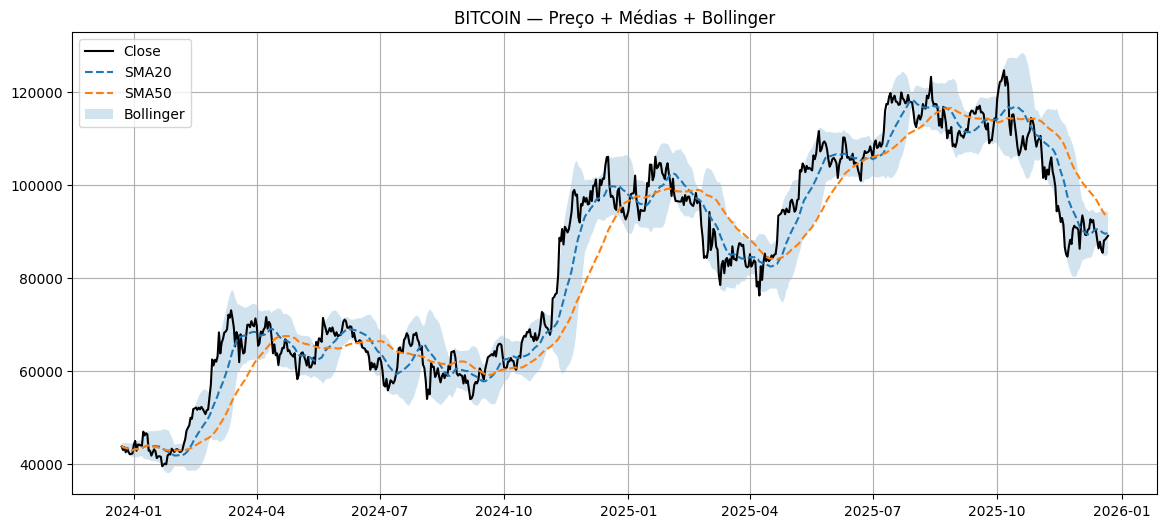

In [0]:
# COMMAND ----------
# GOLD — Plot: Preço + SMA + Bollinger (1 ativo)

import pandas as pd
import matplotlib.pyplot as plt

symbol = "BITCOIN"  # troque livremente

pdf = (
    features_df
    .filter(F.col("symbol") == symbol)
    .orderBy("timestamp")
    .select(
        "timestamp","close","sma20","sma50","boll_upper","boll_lower"
    )
    .dropna()
    .toPandas()
)

plt.figure(figsize=(14,6))
plt.plot(pdf["timestamp"], pdf["close"], label="Close", color="black")
plt.plot(pdf["timestamp"], pdf["sma20"], label="SMA20", linestyle="--")
plt.plot(pdf["timestamp"], pdf["sma50"], label="SMA50", linestyle="--")
plt.fill_between(
    pdf["timestamp"],
    pdf["boll_lower"],
    pdf["boll_upper"],
    alpha=0.2,
    label="Bollinger"
)

plt.title(f"{symbol} — Preço + Médias + Bollinger")
plt.legend()
plt.grid(True)
plt.show()


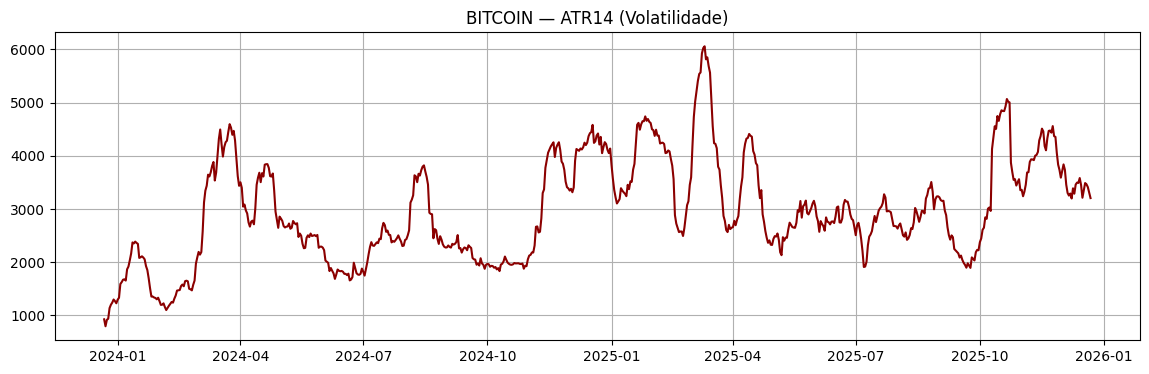

In [0]:
# COMMAND ----------
# GOLD — Plot: ATR14

pdf_atr = (
    features_df
    .filter(F.col("symbol") == symbol)
    .orderBy("timestamp")
    .select("timestamp","atr14")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(14,4))
plt.plot(pdf_atr["timestamp"], pdf_atr["atr14"], color="darkred")
plt.title(f"{symbol} — ATR14 (Volatilidade)")
plt.grid(True)
plt.show()


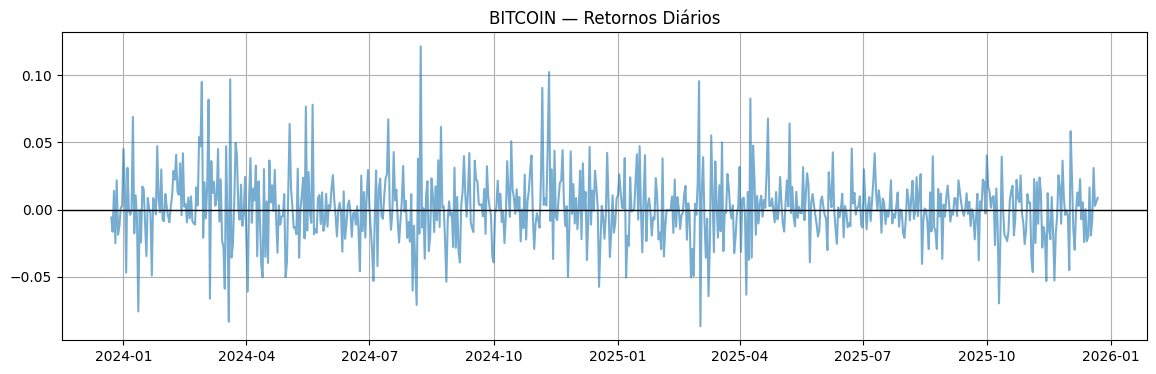

In [0]:
# COMMAND ----------
# GOLD — Plot: Retornos

pdf_ret = (
    features_df
    .filter(F.col("symbol") == symbol)
    .orderBy("timestamp")
    .select("timestamp","retorno")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(14,4))
plt.plot(pdf_ret["timestamp"], pdf_ret["retorno"], alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title(f"{symbol} — Retornos Diários")
plt.grid(True)
plt.show()


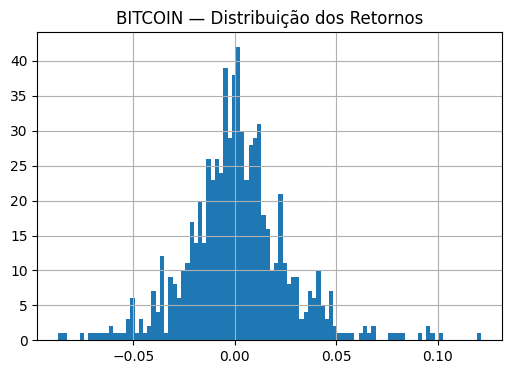

In [0]:
# COMMAND ----------
# GOLD — Histograma de retornos

plt.figure(figsize=(6,4))
plt.hist(pdf_ret["retorno"], bins=100)
plt.title(f"{symbol} — Distribuição dos Retornos")
plt.grid(True)
plt.show()


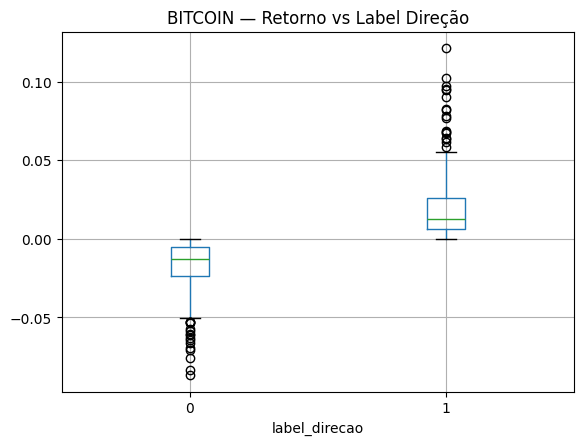

In [0]:
# COMMAND ----------
# GOLD — Label vs Retorno

pdf_lbl = (
    features_df
    .filter(F.col("symbol") == symbol)
    .orderBy("timestamp")
    .select("retorno","label_direcao")
    .dropna()
    .toPandas()
)

pdf_lbl.boxplot(by="label_direcao", column="retorno", grid=True)
plt.title(f"{symbol} — Retorno vs Label Direção")
plt.suptitle("")
plt.show()


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 2.1) Persistência — `gold_asset_features`
# MAGIC Tabela única com features por símbolo, pronta para EDA e modelagem.
# COMMAND ----------
spark.sql("DROP TABLE IF EXISTS gold_asset_features")

features_df.write.format("delta").mode("overwrite").saveAsTable("gold_asset_features")

print("✅ Tabela criada: mvp_finance.gold_asset_features")
spark.sql("SELECT symbol, COUNT(*) AS qtde FROM gold_asset_features GROUP BY symbol ORDER BY qtde DESC").show()



✅ Tabela criada: mvp_finance.gold_asset_features
+-----------+----+
|     symbol|qtde|
+-----------+----+
|    BITCOIN| 731|
|   PETROLEO| 504|
|        DXY| 504|
|     MEXICO| 503|
|TREASURY10Y| 503|
|     NASDAQ| 502|
|   DOWJONES| 502|
|      SP500| 502|
+-----------+----+



In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 3) GOLD — Retornos alinhados (multi-ativo) (`gold_retornos_global`)
# MAGIC
# MAGIC **Base:** `silver_returns_wide`
# MAGIC - contém `trade_date`, preços, colunas `*_prev` e retornos `*_ret`
# MAGIC - é a base canônica para correlação, heatmap e validação de hipóteses
# MAGIC
# MAGIC **Nota:**
# MAGIC Apesar do nome `gold_retornos_global`, a tabela passa a conter retornos **multi-ativo**.
# COMMAND ----------
import pyspark.sql.functions as F

# silver_ret == silver_returns_wide (já carregado antes)
df = silver_ret

if "trade_date" not in df.columns:
    raise RuntimeError("[GOLD RET] silver_returns_wide não possui a coluna trade_date.")

# colunas de preço (base): tudo que não é trade_date e não termina com _prev/_ret
price_cols = [
    c for c in df.columns
    if c != "trade_date" and not c.endswith("_prev") and not c.endswith("_ret")
]

prev_cols = [c for c in df.columns if c.endswith("_prev")]
ret_cols  = [c for c in df.columns if c.endswith("_ret")]

# ordena colunas para ficar estável
price_cols = sorted(price_cols)
prev_cols  = sorted(prev_cols)
ret_cols   = sorted(ret_cols)

gold_ret = (
    df.select("trade_date", *price_cols, *prev_cols, *ret_cols)
      .orderBy("trade_date")
)

display(gold_ret.limit(10))

# COMMAND ----------
spark.sql("DROP TABLE IF EXISTS gold_retornos_global")

gold_ret.write.format("delta").mode("overwrite").saveAsTable("gold_retornos_global")

print("✅ Tabela criada: mvp_finance.gold_retornos_global")
spark.sql("SELECT COUNT(*) AS qtde FROM gold_retornos_global").show()




trade_date BITCOIN DOWJONES MEXICO NASDAQ PETROLEO TREASURY10Y dxy_close sp500_close BITCOIN_prev DOWJONES_prev MEXICO_prev NASDAQ_prev PETROLEO_prev TREASURY10Y_prev dxy_close_prev sp500_close_prev BITCOIN_ret DOWJONES_ret MEXICO_ret NASDAQ_ret PETROLEO_ret TREASURY10Y_ret dxy_close_ret sp500_close_ret 2023-12-19 null null 57694.34 null null 3.92 null null null null null null null null null null null null null null null null null null 2023-12-20 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null 2023-12-21 null 37404.35 57487.7 14963.87 73.89 3.89 101.84 4746.75 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null 0.008692896823256469 0.010162298405341552 0.01258159120960034 null 0.002577319587628857 null 0.01030148882054327 2023-12-22 43997.9 37385.97 57313.47 14992.97 73.56 3.9 101.7 4754.63 null 37404.35 57487.7 14963.87 73.89 3.89 101.84 4746.75 null -4.913866970017722E-4 -0.003030735270327267 0.001944684095758653 -0.004466098254161555 0.0025706940874035134 -0.001374705420267075 0.0016600832148312428 2023-12-23 43739.54 null null null null null 101.7 4754.63 43997.9 37385.97 57313.47 14992.97 73.56 3.9 101.7 4754.63 -0.005872098441061957 null null null null null 0.0 0.0 2023-12-24 43016.12 null null null null null 101.7 4754.63 43739.54 null null null null null 101.7 4754.63 -0.016539268588558476 null null null null null 0.0 0.0 2023-12-25 43613.14 null null null null null 101.7 4754.63 43016.12 null null null null null 101.7 4754.63 0.013878983041706094 null null null null null 0.0 0.0 2023-12-26 42520.4 37545.33 57745.79 15074.57 75.57 3.89 101.47 4774.75 43613.14 null null null null null 101.7 4754.63 -0.025055292969045517 null null null null null -0.002261553588987275 0.0042316647141837915 2023-12-27 43442.86 37656.52 57554.47 15099.18 74.11 3.79 100.99 4781.58 42520.4 37545.33 57745.79 15074.57 75.57 3.89 101.47 4774.75 0.021694527803125085 0.0029614868213967416 -0.0033131419623837477 0.001632550712889369 -0.019319835913722327 -0.02570694087403602 -0.004730462205578045 0.001430441384365766 2023-12-28 42627.86 37710.1 57464.42 15095.14 71.77 3.85 101.23 4783.35 43442.86 37656.52 57554.47 15099.18 74.11 3.79 100.99 4781.58 -0.01876027499110322 0.0014228611672029157 -0.0015646047995925283 -2.6756419885054505E-4 -0.03157468627715565 0.0158311345646438 0.002376472918110828 3.701705294067992E-4

✅ Tabela criada: mvp_finance.gold_retornos_global
+----+
|qtde|
+----+
| 735|
+----+



In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 3.1) Quality Gate — `gold_retornos_global` (multi-ativo)
# MAGIC Validações:
# MAGIC - `trade_date` não nulo e único
# MAGIC - retornos `*_ret` finitos (sem NaN / sem explosões típicas de divisão por zero)
# MAGIC - limites conservadores para alertar outliers
# MAGIC
# MAGIC Observação:
# MAGIC - linhas iniciais podem ter NULL (por conta do `lag`), isso é normal.
# COMMAND ----------
import pyspark.sql.functions as F

# 1) trade_date não nulo
null_td = gold_ret.filter(F.col("trade_date").isNull()).count()
if null_td > 0:
    raise RuntimeError(f"[GOLD RET] trade_date NULL (qtde={null_td})")

# 2) trade_date único
dups_td = gold_ret.groupBy("trade_date").count().filter(F.col("count") > 1).count()
if dups_td > 0:
    raise RuntimeError(f"[GOLD RET] duplicidade por trade_date (qtde={dups_td})")

# 3) identifica colunas de retorno
ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
if not ret_cols:
    raise RuntimeError("[GOLD RET] Nenhuma coluna *_ret encontrada para validação.")

# mantemos apenas linhas com pelo menos 1 retorno não-nulo (para não matar o dataset no início)
ret_clean = gold_ret.filter(
    F.greatest(*[F.col(c).isNotNull().cast("int") for c in ret_cols]) == 1
)

# 4) NaN check
nan_counts = (
    ret_clean
    .select(*[F.sum(F.isnan(F.col(c)).cast("int")).alias(c) for c in ret_cols])
    .collect()[0]
    .asDict()
)

total_nan = sum(nan_counts.values())
if total_nan > 0:
    print("[GOLD RET] NaNs detectados (por coluna):")
    for k, v in sorted(nan_counts.items(), key=lambda kv: kv[1], reverse=True):
        if v > 0:
            print(f"  - {k}: {v}")
    raise RuntimeError(f"[GOLD RET] Existem NaNs em retornos (total={total_nan}).")

# 5) “Inf-like” guard (retornos absurdamente altos geralmente são dado ruim)
INF_GUARD = 10.0  # 1000% (guarda técnica)
inf_like = ret_clean.filter(
    F.greatest(*[F.abs(F.col(c)) for c in ret_cols]) > F.lit(INF_GUARD)
)
inf_cnt = inf_like.count()
if inf_cnt > 0:
    display(inf_like.select("trade_date", *ret_cols).orderBy("trade_date"))
    raise RuntimeError(f"[GOLD RET] Retornos com |ret| > {INF_GUARD} (possível Inf/divisão por zero). qtde={inf_cnt}")

# 6) sanity check conservador
abs_limit = 0.50
bad = ret_clean.filter(
    F.greatest(*[F.abs(F.col(c)) for c in ret_cols]) > F.lit(abs_limit)
)

bad_cnt = bad.count()
if bad_cnt > 0:
    bad_ranked = bad.withColumn(
        "_max_abs_ret",
        F.greatest(*[F.abs(F.col(c)) for c in ret_cols])
    ).orderBy(F.col("_max_abs_ret").desc())

    display(bad_ranked.select("trade_date", "_max_abs_ret", *ret_cols).limit(200))
    raise RuntimeError(f"[GOLD RET] retornos fora do limite ±{abs_limit*100:.0f}% (qtde={bad_cnt})")

print("[GOLD RET] OK")



[GOLD RET] OK


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 3.2) Persistência — `gold_retornos_global`
# COMMAND ----------
spark.sql("DROP TABLE IF EXISTS gold_retornos_global")

gold_ret.write.format("delta").mode("overwrite").saveAsTable("gold_retornos_global")

print("✅ Tabela criada: mvp_finance.gold_retornos_global")
spark.sql("SELECT COUNT(*) AS qtde FROM gold_retornos_global").show()


✅ Tabela criada: mvp_finance.gold_retornos_global
+----+
|qtde|
+----+
| 735|
+----+



In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 4) GOLD — Correlações (global e dinâmica) (multi-ativo)
# MAGIC
# MAGIC Produzimos:
# MAGIC - **Correlação global (Pearson)** no período para **todos os pares** de ativos (retornos)
# MAGIC - **Correlação rolling 21d** para **todos os pares** (evidência de mudança estrutural)
# MAGIC
# MAGIC Saídas (recomendado):
# MAGIC - `gold_corr_pairs_global` (1 linha por par no período inteiro)
# MAGIC - `gold_corr_pairs_rolling_21d` (série temporal por par)
# COMMAND ----------
import pyspark.sql.functions as F
from itertools import combinations
from pyspark.sql.window import Window

# ret_cols: todas as colunas *_ret presentes em gold_ret
ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
if not ret_cols:
    raise RuntimeError("[GOLD CORR] Nenhuma coluna *_ret encontrada em gold_ret.")

# nomes "limpos" dos ativos (remove _ret)
assets = [c.replace("_ret", "") for c in ret_cols]

print("[GOLD CORR] ativos detectados:", assets)
# COMMAND ----------
# Gera expressões corr(col_i, col_j) para todos os pares
pair_exprs = []
pairs = list(combinations(ret_cols, 2))

for a, b in pairs:
    a_name = a.replace("_ret", "")
    b_name = b.replace("_ret", "")
    pair_exprs.append(F.corr(F.col(a), F.col(b)).alias(f"corr__{a_name}__{b_name}"))

# Uma linha com todas as correlações (wide)
corr_wide = gold_ret.select(*pair_exprs)

display(corr_wide)
# COMMAND ----------
# Traz para driver (pouquíssimo dado: só 1 linha)
row = corr_wide.collect()[0].asDict()

corr_rows = []
for k, v in row.items():
    # k = "corr__A__B"
    _, a, b = k.split("__")
    corr_rows.append((a, b, float(v) if v is not None else None))

corr_global_pairs = spark.createDataFrame(corr_rows, ["asset_a", "asset_b", "corr_pearson"])

display(corr_global_pairs.orderBy(F.col("corr_pearson").desc_nulls_last()))
# COMMAND ----------
spark.sql("DROP TABLE IF EXISTS gold_corr_pairs_global")
corr_global_pairs.write.format("delta").mode("overwrite").saveAsTable("gold_corr_pairs_global")
print("✅ Tabela criada: mvp_finance.gold_corr_pairs_global")




[GOLD CORR] ativos detectados: ['BITCOIN', 'DOWJONES', 'MEXICO', 'NASDAQ', 'PETROLEO', 'TREASURY10Y', 'dxy_close', 'sp500_close']


corr__BITCOIN__DOWJONES corr__BITCOIN__MEXICO corr__BITCOIN__NASDAQ corr__BITCOIN__PETROLEO corr__BITCOIN__TREASURY10Y corr__BITCOIN__dxy_close corr__BITCOIN__sp500_close corr__DOWJONES__MEXICO corr__DOWJONES__NASDAQ corr__DOWJONES__PETROLEO corr__DOWJONES__TREASURY10Y corr__DOWJONES__dxy_close corr__DOWJONES__sp500_close corr__MEXICO__NASDAQ corr__MEXICO__PETROLEO corr__MEXICO__TREASURY10Y corr__MEXICO__dxy_close corr__MEXICO__sp500_close corr__NASDAQ__PETROLEO corr__NASDAQ__TREASURY10Y corr__NASDAQ__dxy_close corr__NASDAQ__sp500_close corr__PETROLEO__TREASURY10Y corr__PETROLEO__dxy_close corr__PETROLEO__sp500_close corr__TREASURY10Y__dxy_close corr__TREASURY10Y__sp500_close corr__dxy_close__sp500_close 0.35349790385473995 0.22760254088033377 0.40375067263893116 0.08677489746933649 0.08080272709766684 -0.033935925583465025 0.3369033534231022 0.4007613949605345 0.7881502079960018 0.13903459786281303 0.06774885013092066 0.017929610150703344 0.8964621161570997 0.417304211938109 0.1410794270518917 0.02304920252413665 -0.17379299192577446 0.43241507695798503 0.19917483552479043 0.14267855640817861 0.05419327780369089 0.9676041454550249 0.27861049611359345 0.13186833159770647 0.1969464609039713 0.41939559952902505 0.11588944428476151 0.05022866671332412

asset_a asset_b corr_pearson NASDAQ sp500_close 0.9676041454550249 DOWJONES sp500_close 0.8964621161570997 DOWJONES NASDAQ 0.7881502079960018 MEXICO sp500_close 0.43241507695798503 TREASURY10Y dxy_close 0.41939559952902505 MEXICO NASDAQ 0.417304211938109 BITCOIN NASDAQ 0.40375067263893116 DOWJONES MEXICO 0.4007613949605345 BITCOIN DOWJONES 0.35349790385473995 BITCOIN sp500_close 0.3369033534231022 PETROLEO TREASURY10Y 0.27861049611359345 BITCOIN MEXICO 0.22760254088033377 NASDAQ PETROLEO 0.19917483552479043 PETROLEO sp500_close 0.1969464609039713 NASDAQ TREASURY10Y 0.14267855640817861 MEXICO PETROLEO 0.1410794270518917 DOWJONES PETROLEO 0.13903459786281303 PETROLEO dxy_close 0.13186833159770647 TREASURY10Y sp500_close 0.11588944428476151 BITCOIN PETROLEO 0.08677489746933649 BITCOIN TREASURY10Y 0.08080272709766684 DOWJONES TREASURY10Y 0.06774885013092066 NASDAQ dxy_close 0.05419327780369089 dxy_close sp500_close 0.05022866671332412 MEXICO TREASURY10Y 0.02304920252413665 DOWJONES dxy_close 0.017929610150703344 BITCOIN dxy_close -0.033935925583465025 MEXICO dxy_close -0.17379299192577446

✅ Tabela criada: mvp_finance.gold_corr_pairs_global


In [0]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

w21 = Window.orderBy("trade_date").rowsBetween(-20, 0)

def rolling_corr_safe(df, x, y, out, min_points=10, eps=1e-12):
    """
    Rolling corr robusta:
    - exige min_points válidos na janela
    - evita divisão por zero (stddev=0)
    - clampa pequenas violações numéricas para [-1, 1]
    """
    xcol = F.col(x)
    ycol = F.col(y)

    # quantos pares (x,y) não-nulos na janela
    n = F.count(xcol * ycol).over(w21)

    ex  = F.avg(xcol).over(w21)
    ey  = F.avg(ycol).over(w21)
    exy = F.avg(xcol * ycol).over(w21)

    cov = exy - (ex * ey)
    sx  = F.stddev(xcol).over(w21)
    sy  = F.stddev(ycol).over(w21)

    denom = sx * sy
    raw = cov / denom

    # validade: pontos suficientes e denom > 0
    valid = (n >= F.lit(min_points)) & denom.isNotNull() & (denom > F.lit(0))

    # clamp para tolerar artefatos numéricos mínimos
    clamped = (
        F.when(raw > F.lit(1) + F.lit(eps), F.lit(1.0))
         .when(raw < F.lit(-1) - F.lit(eps), F.lit(-1.0))
         .otherwise(raw)
    )

    return df.withColumn(out, F.when(valid, clamped).otherwise(F.lit(None)))


In [0]:
from itertools import combinations

ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
pairs = list(combinations(ret_cols, 2))

df_roll = (
    gold_ret
    .select("trade_date", *ret_cols)
    .orderBy("trade_date")
)

out_cols = []
for a, b in pairs:
    a_name = a.replace("_ret", "")
    b_name = b.replace("_ret", "")
    out = f"corr__{a_name}__{b_name}__21d"
    df_roll = rolling_corr_safe(df_roll, a, b, out, min_points=10)
    out_cols.append(out)

# long format: (trade_date, asset_a, asset_b, corr_21d)
expr_stack = []
for out in out_cols:
    _, a, b, _ = out.split("__")
    expr_stack.append(
        F.struct(
            F.lit(a).alias("asset_a"),
            F.lit(b).alias("asset_b"),
            F.col(out).alias("corr_21d")
        )
    )

corr_roll_long = (
    df_roll
    .select("trade_date", F.explode(F.array(*expr_stack)).alias("x"))
    .select("trade_date", "x.asset_a", "x.asset_b", "x.corr_21d")
)

display(corr_roll_long.orderBy("trade_date").limit(50))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


trade_date asset_a asset_b corr_21d 2023-12-19 NASDAQ sp500_close null 2023-12-19 DOWJONES dxy_close null 2023-12-19 DOWJONES NASDAQ null 2023-12-19 BITCOIN PETROLEO null 2023-12-19 BITCOIN DOWJONES null 2023-12-19 TREASURY10Y sp500_close null 2023-12-19 MEXICO NASDAQ null 2023-12-19 DOWJONES MEXICO null 2023-12-19 BITCOIN NASDAQ null 2023-12-19 MEXICO TREASURY10Y null 2023-12-19 DOWJONES PETROLEO null 2023-12-19 PETROLEO dxy_close null 2023-12-19 TREASURY10Y dxy_close null 2023-12-19 dxy_close sp500_close null 2023-12-19 MEXICO dxy_close null 2023-12-19 DOWJONES TREASURY10Y null 2023-12-19 BITCOIN MEXICO null 2023-12-19 NASDAQ TREASURY10Y null 2023-12-19 NASDAQ dxy_close null 2023-12-19 MEXICO sp500_close null 2023-12-19 NASDAQ PETROLEO null 2023-12-19 MEXICO PETROLEO null 2023-12-19 PETROLEO sp500_close null 2023-12-19 BITCOIN sp500_close null 2023-12-19 BITCOIN dxy_close null 2023-12-19 PETROLEO TREASURY10Y null 2023-12-19 BITCOIN TREASURY10Y null 2023-12-19 DOWJONES sp500_close null 2023-12-20 BITCOIN DOWJONES null 2023-12-20 BITCOIN MEXICO null 2023-12-20 NASDAQ PETROLEO null 2023-12-20 NASDAQ TREASURY10Y null 2023-12-20 NASDAQ dxy_close null 2023-12-20 MEXICO PETROLEO null 2023-12-20 DOWJONES sp500_close null 2023-12-20 MEXICO TREASURY10Y null 2023-12-20 DOWJONES TREASURY10Y null 2023-12-20 DOWJONES dxy_close null 2023-12-20 MEXICO dxy_close null 2023-12-20 BITCOIN dxy_close null 2023-12-20 BITCOIN sp500_close null 2023-12-20 DOWJONES PETROLEO null 2023-12-20 BITCOIN TREASURY10Y null 2023-12-20 DOWJONES MEXICO null 2023-12-20 BITCOIN NASDAQ null 2023-12-20 MEXICO NASDAQ null 2023-12-20 BITCOIN PETROLEO null 2023-12-20 DOWJONES NASDAQ null 2023-12-20 MEXICO sp500_close null 2023-12-20 NASDAQ sp500_close null

In [0]:
# tolerância numérica
TOL = 1e-6

bad_corr = (
    corr_roll_long
    .dropna(subset=["corr_21d"])
    .filter((F.col("corr_21d") > F.lit(1 + TOL)) | (F.col("corr_21d") < F.lit(-1 - TOL)))
    .count()
)

if bad_corr > 0:
    display(
        corr_roll_long
        .dropna(subset=["corr_21d"])
        .filter((F.col("corr_21d") > F.lit(1 + TOL)) | (F.col("corr_21d") < F.lit(-1 - TOL)))
        .orderBy("trade_date")
    )
    raise RuntimeError(f"[GOLD CORR ROLL] valores fora de [-1,1] além da tolerância (qtde={bad_corr})")

print("[GOLD CORR ROLL] OK — robusto com clamp/guard")

spark.sql("DROP TABLE IF EXISTS mvp_finance.gold_corr_pairs_rolling_21d")
corr_roll_long.write.format("delta").mode("overwrite").saveAsTable("mvp_finance.gold_corr_pairs_rolling_21d")
print("✅ Tabela criada: mvp_finance.gold_corr_pairs_rolling_21d")



/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


[GOLD CORR ROLL] OK — robusto com clamp/guard
✅ Tabela criada: mvp_finance.gold_corr_pairs_rolling_21d


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 4.1) Correlação dinâmica (rolling 21d) — multi-ativo
# MAGIC Implementação via janelas (fórmula rolling):
# MAGIC
# MAGIC corr(X,Y) = cov(X,Y) / (std(X)*std(Y))
# MAGIC cov = E[XY] - E[X]E[Y]
# MAGIC
# MAGIC **Janela:** 21 pregões (ajustável).
# MAGIC
# MAGIC **Saída (recomendada):**
# MAGIC - `gold_corr_pairs_rolling_21d` (formato longo: trade_date + par + correlação)
# COMMAND ----------
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from itertools import combinations

# Janela rolling: 21 (inclui o dia atual)
w21 = Window.orderBy("trade_date").rowsBetween(-20, 0)

def rolling_corr(df, x, y, out):
    ex  = F.avg(F.col(x)).over(w21)
    ey  = F.avg(F.col(y)).over(w21)
    exy = F.avg((F.col(x) * F.col(y))).over(w21)
    cov = exy - (ex * ey)
    sx  = F.stddev(F.col(x)).over(w21)
    sy  = F.stddev(F.col(y)).over(w21)
    return df.withColumn(out, cov / (sx * sy))

# detecta retornos disponíveis
ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
if not ret_cols:
    raise RuntimeError("[GOLD CORR ROLL] Nenhuma coluna *_ret encontrada em gold_ret.")

pairs = list(combinations(ret_cols, 2))

# base mínima para rolling
df_roll = gold_ret.select("trade_date", *ret_cols).orderBy("trade_date")

# calcula rolling para todos os pares, gerando colunas corr__A__B__21d
out_cols = []
for a, b in pairs:
    a_name = a.replace("_ret", "")
    b_name = b.replace("_ret", "")
    out = f"corr__{a_name}__{b_name}__21d"
    df_roll = rolling_corr(df_roll, a, b, out)
    out_cols.append(out)

# converte para formato longo: (trade_date, asset_a, asset_b, corr_21d)
stack_structs = []
for out in out_cols:
    # out = corr__A__B__21d
    _, a_name, b_name, _ = out.split("__")
    stack_structs.append(
        F.struct(
            F.lit(a_name).alias("asset_a"),
            F.lit(b_name).alias("asset_b"),
            F.col(out).alias("corr_21d")
        )
    )

corr_roll_long = (
    df_roll
    .select("trade_date", F.explode(F.array(*stack_structs)).alias("x"))
    .select("trade_date", "x.asset_a", "x.asset_b", "x.corr_21d")
)

display(corr_roll_long.orderBy("trade_date").limit(30))


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


trade_date asset_a asset_b corr_21d 2023-12-19 NASDAQ sp500_close null 2023-12-19 DOWJONES dxy_close null 2023-12-19 MEXICO dxy_close null 2023-12-19 NASDAQ dxy_close null 2023-12-19 PETROLEO sp500_close null 2023-12-19 dxy_close sp500_close null 2023-12-19 DOWJONES PETROLEO null 2023-12-19 MEXICO TREASURY10Y null 2023-12-19 MEXICO sp500_close null 2023-12-19 NASDAQ TREASURY10Y null 2023-12-19 MEXICO NASDAQ null 2023-12-19 PETROLEO dxy_close null 2023-12-19 TREASURY10Y dxy_close null 2023-12-19 TREASURY10Y sp500_close null 2023-12-19 BITCOIN DOWJONES null 2023-12-19 BITCOIN sp500_close null 2023-12-19 BITCOIN PETROLEO null 2023-12-19 MEXICO PETROLEO null 2023-12-19 BITCOIN NASDAQ null 2023-12-19 DOWJONES NASDAQ null 2023-12-19 DOWJONES MEXICO null 2023-12-19 NASDAQ PETROLEO null 2023-12-19 BITCOIN MEXICO null 2023-12-19 DOWJONES TREASURY10Y null 2023-12-19 BITCOIN dxy_close null 2023-12-19 PETROLEO TREASURY10Y null 2023-12-19 BITCOIN TREASURY10Y null 2023-12-19 DOWJONES sp500_close null 2023-12-20 BITCOIN DOWJONES null 2023-12-20 BITCOIN MEXICO null

In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC #### Quality Gate — rolling corr em [-1, 1] quando não nula
# COMMAND ----------
from pyspark.sql import Window
import pyspark.sql.functions as F

w21 = Window.orderBy("trade_date").rowsBetween(-20, 0)

def rolling_corr_safe(df, x, y, out, min_points=10, eps=1e-9):
    """
    Rolling corr robusta:
    - exige um mínimo de pontos válidos (min_points) para calcular
    - evita divisão por zero (stddev = 0 ou NULL)
    - clampa pequenos overshoots numéricos em [-1,1]
    """
    cx  = F.count(F.col(x)).over(w21)
    cy  = F.count(F.col(y)).over(w21)
    cxy = F.count(F.col(x) * F.col(y)).over(w21)  # conta linhas onde ambos existem
    ex  = F.avg(F.col(x)).over(w21)
    ey  = F.avg(F.col(y)).over(w21)
    exy = F.avg(F.col(x) * F.col(y)).over(w21)
    cov = exy - (ex * ey)
    sx  = F.stddev(F.col(x)).over(w21)
    sy  = F.stddev(F.col(y)).over(w21)

    denom = sx * sy
    raw = cov / denom

    # condições de validade
    valid = (
        (cxy >= F.lit(min_points)) &
        denom.isNotNull() &
        (denom > F.lit(0))
    )

    # clamp numérico: aceita pequeno overshoot por eps
    clamped = (
        F.when(raw > F.lit(1) + F.lit(eps), F.lit(1))
         .when(raw < F.lit(-1) - F.lit(eps), F.lit(-1))
         .otherwise(raw)
    )

    return df.withColumn(out, F.when(valid, clamped).otherwise(F.lit(None)))
    from itertools import combinations

    ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
    pairs = list(combinations(ret_cols, 2))
    df_roll = gold_ret.select("trade_date", *ret_cols).orderBy("trade_date")
    out_cols = []
    for a, b in pairs:
        a_name = a.replace("_ret", "")
        b_name = b.replace("_ret", "")
        out = f"corr__{a_name}__{b_name}__21d"
        df_roll = rolling_corr_safe(df_roll, a, b, out, min_points=10, eps=1e-9)
        out_cols.append(out)
    stack_structs = []
    for out in out_cols:
        _, a_name, b_name, _ = out.split("__")
        stack_structs.append(
            F.struct(
                F.lit(a_name).alias("asset_a"),
                F.lit(b_name).alias("asset_b"),
                F.col(out).alias("corr_21d")
            )
        )

    corr_roll_long = (
        df_roll
        .select("trade_date", F.explode(F.array(*stack_structs)).alias("x"))
        .select("trade_date", "x.asset_a", "x.asset_b", "x.corr_21d")
    )

    display(corr_roll_long.orderBy("trade_date").limit(30))
    tol = 1e-6
    bad_corr = (
        corr_roll_long
        .dropna(subset=["corr_21d"])
        .filter((F.col("corr_21d") > F.lit(1 + tol)) | (F.col("corr_21d") < F.lit(-1 - tol)))
        .count()
    )

    if bad_corr > 0:
        display(
            corr_roll_long
            .dropna(subset=["corr_21d"])
            .filter((F.col("corr_21d") > F.lit(1 + tol)) | (F.col("corr_21d") < F.lit(-1 - tol)))
            .orderBy("trade_date")
            .limit(200)
        )
        raise RuntimeError(f"[GOLD CORR ROLL] valores fora de [-1,1] além da tolerância (qtde={bad_corr})")

    print("[GOLD CORR ROLL] OK")

    spark.sql("DROP TABLE IF EXISTS gold_corr_pairs_rolling_21d")
    corr_roll_long.write.format("delta").mode("overwrite").saveAsTable("gold_corr_pairs_rolling_21d")
    print("✅ Tabela criada: mvp_finance.gold_corr_pairs_rolling_21d")



In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## Heatmap — Matriz de correlação global (retornos, multi-ativo)
# MAGIC
# MAGIC - Fonte: `gold_corr_pairs_global`
# MAGIC - Correlação de Pearson no período inteiro
# MAGIC - Funciona automaticamente para N ativos
# COMMAND ----------
import pandas as pd
import plotly.express as px

# lê da Gold (fonte oficial)
corr_pairs_pd = (
    spark.table("gold_corr_pairs_global")
    .toPandas()
)

# lista completa de ativos
assets = sorted(
    set(corr_pairs_pd["asset_a"]).union(corr_pairs_pd["asset_b"])
)

# inicializa matriz identidade
corr_matrix = pd.DataFrame(
    data=1.0,
    index=assets,
    columns=assets
)

# preenche pares
for _, row in corr_pairs_pd.iterrows():
    a, b, v = row["asset_a"], row["asset_b"], row["corr_pearson"]
    corr_matrix.loc[a, b] = v
    corr_matrix.loc[b, a] = v  # simetria

# heatmap
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",
    aspect="auto",
    zmin=-1, zmax=1,
    color_continuous_scale="RdBu_r",
    title="Matriz de Correlação Global — Retornos (Pearson)"
)

fig.update_layout(
    xaxis_title="Ativo",
    yaxis_title="Ativo"
)

fig.show()



In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ## 5) GOLD — Tabela analítica unificada (multi-ativo) (`gold_analytics_assets`)
# MAGIC
# MAGIC Junta (por **ativo** e **dia**):
# MAGIC - Features técnicas do ativo (Gold features)
# MAGIC - Retornos/preços wide (contexto multi-ativo)
# MAGIC - Correlações rolling 21d do ativo vs demais
# MAGIC
# MAGIC Resultado: dataset pronto para EDA, validação de hipóteses e ML.
# COMMAND ----------
spark.sql("USE mvp_finance")

import pyspark.sql.functions as F
from pyspark.sql.window import Window
from itertools import combinations

def table_exists(db: str, name: str) -> bool:
    try:
        spark.table(f"{db}.{name}")
        return True
    except Exception:
        return False

DB = "mvp_finance"

# possíveis nomes (caso você tenha persistido com nomes antigos)
CANDIDATES = [
    "gold_corr_pairs_rolling_21d",
    "gold_corr_ibov_global_rolling",
    "gold_corr_pairs_rolling_21d".lower(),
    "gold_corr_ibov_global_rolling".lower(),
]

rolling_table = next((t for t in CANDIDATES if table_exists(DB, t)), None)

gold_ret = spark.table(f"{DB}.gold_retornos_global").withColumnRenamed("trade_date", "trade_date")  # só garantindo referência

if rolling_table:
    print(f"[OK] Usando rolling existente: {DB}.{rolling_table}")
    corr_roll_long = (
        spark.table(f"{DB}.{rolling_table}")
        .select("trade_date", "asset_a", "asset_b", "corr_21d")
    )
else:
    print("[INFO] Rolling não encontrado em tabela. Recalculando a partir de gold_retornos_global...")

    # detecta todas colunas *_ret
    ret_cols = [c for c in gold_ret.columns if c.endswith("_ret")]
    if not ret_cols:
        raise RuntimeError("[ROLLING] gold_retornos_global não possui colunas *_ret.")

    pairs = list(combinations(ret_cols, 2))

    w21 = Window.orderBy("trade_date").rowsBetween(-20, 0)

    def rolling_corr_safe(df, x, y, out, min_points=10, eps=1e-9):
        cxy = F.count(F.col(x) * F.col(y)).over(w21)
        ex  = F.avg(F.col(x)).over(w21)
        ey  = F.avg(F.col(y)).over(w21)
        exy = F.avg(F.col(x) * F.col(y)).over(w21)
        cov = exy - (ex * ey)
        sx  = F.stddev(F.col(x)).over(w21)
        sy  = F.stddev(F.col(y)).over(w21)
        denom = sx * sy
        raw = cov / denom

        valid = (cxy >= F.lit(min_points)) & denom.isNotNull() & (denom > F.lit(0))

        clamped = (
            F.when(raw > F.lit(1) + F.lit(eps), F.lit(1))
             .when(raw < F.lit(-1) - F.lit(eps), F.lit(-1))
             .otherwise(raw)
        )
        return df.withColumn(out, F.when(valid, clamped).otherwise(F.lit(None)))

    df_roll = gold_ret.select("trade_date", *ret_cols).orderBy("trade_date")

    out_cols = []
    for a, b in pairs:
        a_name = a.replace("_ret", "")
        b_name = b.replace("_ret", "")
        out = f"corr__{a_name}__{b_name}__21d"
        df_roll = rolling_corr_safe(df_roll, a, b, out)
        out_cols.append(out)

    # formato longo
    stack_structs = []
    for out in out_cols:
        _, a_name, b_name, _ = out.split("__")
        stack_structs.append(
            F.struct(
                F.lit(a_name).alias("asset_a"),
                F.lit(b_name).alias("asset_b"),
                F.col(out).alias("corr_21d")
            )
        )

    corr_roll_long = (
        df_roll
        .select("trade_date", F.explode(F.array(*stack_structs)).alias("x"))
        .select("trade_date", "x.asset_a", "x.asset_b", "x.corr_21d")
    )

    # persiste (opcional, mas recomendado)
    spark.sql(f"DROP TABLE IF EXISTS {DB}.gold_corr_pairs_rolling_21d")
    corr_roll_long.write.format("delta").mode("overwrite").saveAsTable(f"{DB}.gold_corr_pairs_rolling_21d")
    print(f"✅ Tabela criada: {DB}.gold_corr_pairs_rolling_21d")

gold_features = spark.table("gold_asset_features")
gold_ret_wide  = spark.table("gold_retornos_global")
# corr_roll_long já está definido pelo resolver acima
ret_small = gold_ret_wide.withColumnRenamed("trade_date", "date")

corr_sym = (
    corr_roll_long
    .withColumnRenamed("trade_date", "date")
)


[OK] Usando rolling existente: mvp_finance.gold_corr_pairs_rolling_21d


In [0]:
import pyspark.sql.functions as F

spark.sql("USE mvp_finance")

# =========================
# 1) Fontes Gold existentes
# =========================
gold_features = spark.table("gold_asset_features")              # por symbol + date
gold_ret      = spark.table("gold_retornos_global")             # contexto global (wide)
corr_roll     = spark.table("gold_corr_pairs_rolling_21d")      # long: date, asset_a, asset_b, corr_21d

# =========================
# 2) Retornos (padroniza chave)
# =========================
ret_small = (
    gold_ret
    .withColumnRenamed("trade_date", "date")
)

# =========================
# 3) Correlação rolling → pivot por (date, symbol)
# =========================
corr_sym = (
    corr_roll
    .withColumnRenamed("trade_date", "date")
)

corr_as_a = corr_sym.select(
    "date",
    F.col("asset_a").alias("symbol"),
    F.col("asset_b").alias("other"),
    "corr_21d"
)

corr_as_b = corr_sym.select(
    "date",
    F.col("asset_b").alias("symbol"),
    F.col("asset_a").alias("other"),
    "corr_21d"
)

corr_long = corr_as_a.unionByName(corr_as_b)

corr_pivot = (
    corr_long
    .groupBy("date", "symbol")
    .pivot("other")
    .agg(F.first("corr_21d"))
)

# renomeia colunas de correlação
for c in corr_pivot.columns:
    if c not in ("date", "symbol"):
        corr_pivot = corr_pivot.withColumnRenamed(c, f"corr_21d__{c}")

# =========================
# 4) Features por ativo
# =========================
feat_small = gold_features.select(
    "symbol",
    "date",
    "timestamp",
    "open","high","low","close","volume",
    "retorno","retorno_log",
    "sma20","sma50",
    "boll_upper","boll_lower",
    "atr14",
    "label_direcao"
)

# =========================
# 5) JOIN FINAL
# =========================
gold_analytics_assets = (
    feat_small.alias("f")
    .join(ret_small.alias("r"), ["date"], "inner")
    .join(corr_pivot.alias("c"), ["date", "symbol"], "left")
)

display(gold_analytics_assets.orderBy("date", "symbol").limit(20))

# =========================
# 6) Persistência DEFINITIVA
# =========================
spark.sql("DROP TABLE IF EXISTS mvp_finance.gold_analytics_assets")

(
    gold_analytics_assets
    .write
    .format("delta")
    .mode("overwrite")
    .saveAsTable("mvp_finance.gold_analytics_assets")
)

print("✅ Tabela criada: mvp_finance.gold_analytics_assets")


date symbol timestamp open high low close volume retorno retorno_log sma20 sma50 boll_upper boll_lower atr14 label_direcao BITCOIN DOWJONES MEXICO NASDAQ PETROLEO TREASURY10Y dxy_close sp500_close BITCOIN_prev DOWJONES_prev MEXICO_prev NASDAQ_prev PETROLEO_prev TREASURY10Y_prev dxy_close_prev sp500_close_prev BITCOIN_ret DOWJONES_ret MEXICO_ret NASDAQ_ret PETROLEO_ret TREASURY10Y_ret dxy_close_ret sp500_close_ret corr_21d__BITCOIN corr_21d__DOWJONES corr_21d__MEXICO corr_21d__NASDAQ corr_21d__PETROLEO corr_21d__TREASURY10Y corr_21d__dxy_close corr_21d__sp500_close 2023-12-19 MEXICO 2023-12-19T00:00:00.000Z 57737.41 58338.32 57374.39 57694.34 2.189417E8 null null 57694.34 57694.34 null null 963.9300000000003 0 null null 57694.34 null null 3.92 null null null null null null null null null null null null null null null null null null null null null null null null null null 2023-12-19 TREASURY10Y 2023-12-19T00:00:00.000Z 3.9 3.93 3.9 3.92 0.0 null null 3.92 3.92 null null 0.03000000000000025 0 null null 57694.34 null null 3.92 null null null null null null null null null null null null null null null null null null null null null null null null null null 2023-12-20 DOWJONES 2023-12-20T00:00:00.000Z 37520.13 37641.3 37073.04 37082.0 3.0345E8 null null 37082.0 37082.0 null null 568.260000000002 0 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null null null null null null null null null 2023-12-20 MEXICO 2023-12-20T00:00:00.000Z 57689.35 57826.89 56811.44 56909.37 2.062199E8 -0.013605667384356868 -0.013699072671984235 57301.854999999996 57301.854999999996 58411.970220056 56191.73977994399 989.6899999999987 0 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null null null null null null null null null 2023-12-20 NASDAQ 2023-12-20T00:00:00.000Z 14973.36 15069.29 14776.29 14777.94 6.2947E9 null null 14777.94 14777.94 null null 293.0 0 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null null null null null null null null null 2023-12-20 SP500 2023-12-20T00:00:00.000Z 4764.73 4778.01 4697.82 4698.35 4.20132E9 null null 4698.35 4698.35 null null 80.19000000000051 0 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null null null null null null null null null 2023-12-20 TREASURY10Y 2023-12-20T00:00:00.000Z 3.88 3.92 3.87 3.88 0.0 -0.010204081632653073 -0.01025650016718911 3.9 3.9 3.956568542494924 3.843431457505076 0.040000000000000036 0 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null null 57694.34 null null 3.92 null null null null -0.013605667384356868 null null -0.010204081632653073 null null null null null null null null null null 2023-12-21 DOWJONES 2023-12-21T00:00:00.000Z 37225.32 37418.76 37127.05 37404.35 2.5312E8 0.008692896823256469 0.008655331141750088 37243.175 37243.175 37699.04674183097 36787.303258169035 452.51000000000204 1 null 37404.35 57487.7 14963.87 73.89 3.89 101.84 4746.75 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null 0.008692896823256469 0.010162298405341552 0.01258159120960034 null 0.002577319587628857 null 0.01030148882054327 null null null null null null null null 2023-12-21 DXY 2023-12-21T00:00:00.000Z 102.39 102.45 101.74 101.84 0.0 null null 101.84 101.84 null null 0.710000000000008 0 null 37404.35 57487.7 14963.87 73.89 3.89 101.84 4746.75 null 37082.0 56909.37 14777.94 null 3.88 null 4698.35 null 0.008692896823256469 0.010162298405341552 0.01258159120960034 null 0.002577319587628857 null 0.01030148882054327 null null null null null null null null 2023-12-21 MEXICO 2023-12-21T00:00:00.000Z 56998.77 57599.91 56998.77 57

✅ Tabela criada: mvp_finance.gold_analytics_assets


In [0]:
gold_final = spark.table("mvp_finance.gold_analytics_assets")
gold_final.count()
gold_final.display()


date symbol timestamp open high low close volume retorno retorno_log sma20 sma50 boll_upper boll_lower atr14 label_direcao BITCOIN DOWJONES MEXICO NASDAQ PETROLEO TREASURY10Y dxy_close sp500_close BITCOIN_prev DOWJONES_prev MEXICO_prev NASDAQ_prev PETROLEO_prev TREASURY10Y_prev dxy_close_prev sp500_close_prev BITCOIN_ret DOWJONES_ret MEXICO_ret NASDAQ_ret PETROLEO_ret TREASURY10Y_ret dxy_close_ret sp500_close_ret corr_21d__BITCOIN corr_21d__DOWJONES corr_21d__MEXICO corr_21d__NASDAQ corr_21d__PETROLEO corr_21d__TREASURY10Y corr_21d__dxy_close corr_21d__sp500_close 2023-12-22 BITCOIN 2023-12-22T00:00:00.000Z 43868.99 44367.96 43441.97 43997.9 2.1028503216E10 null null 43997.9 43997.9 null null 925.989999999998 0 43997.9 37385.97 57313.47 14992.97 73.56 3.9 101.7 4754.63 null 37404.35 57487.7 14963.87 73.89 3.89 101.84 4746.75 null -4.913866970017722E-4 -0.003030735270327267 0.001944684095758653 -0.004466098254161555 0.0025706940874035134 -0.001374705420267075 0.0016600832148312428 null null null null null null null null 2023-12-23 BITCOIN 2023-12-23T00:00:00.000Z 44012.2 44015.7 43351.36 43739.54 1.3507796558E10 -0.005872098441061957 -0.005889407002759387 43868.72 43868.72 44234.096215974714 43503.34378402529 795.1649999999972 0 43739.54 null null null null null 101.7 4754.63 43997.9 37385.97 57313.47 14992.97 73.56 3.9 101.7 4754.63 -0.005872098441061957 null null null null null 0.0 0.0 null null null null null null null null 2023-12-24 BITCOIN 2023-12-24T00:00:00.000Z 43728.37 43945.52 42786.92 43016.12 1.8830554085E10 -0.016539268588558476 -0.01667756934064452 43584.52 43584.52 44602.35376324427 42566.686236755726 916.3099999999977 0 43016.12 null null null null null 101.7 4754.63 43739.54 null null null null null 101.7 4754.63 -0.016539268588558476 null null null null null 0.0 0.0 null null null null null null null null 2023-12-25 BITCOIN 2023-12-25T00:00:00.000Z 43010.57 43765.09 42765.77 43613.14 2.111579537E10 0.013878983041706094 0.013783551933961542 43591.675 43591.675 44423.22544994276 42760.12455005725 937.0624999999982 1 43613.14 null null null null null 101.7 4754.63 43016.12 null null null null null 101.7 4754.63 0.013878983041706094 null null null null null 0.0 0.0 null null null null null null null null 2023-12-26 BITCOIN 2023-12-26T00:00:00.000Z 43599.85 43603.18 41676.49 42520.4 3.0026850982E10 -0.025055292969045517 -0.02537452032988713 43377.42 43377.42 44576.048889022786 42178.79111097721 1136.9799999999989 0 42520.4 37545.33 57745.79 15074.57 75.57 3.89 101.47 4774.75 43613.14 null null null null null 101.7 4754.63 -0.025055292969045517 null null null null null -0.002261553588987275 0.0042316647141837915 null null null null null null null null 2023-12-27 BITCOIN 2023-12-27T00:00:00.000Z 42518.47 43683.16 42167.58 43442.86 2.5260941032E10 0.021694527803125085 0.021462550628621138 43388.32666666667 43388.32666666667 44461.74359402838 42314.90973930495 1200.0799999999992 1 43442.86 37656.52 57554.47 15099.18 74.11 3.79 100.99 4781.58 42520.4 37545.33 57745.79 15074.57 75.57 3.89 101.47 4774.75 0.021694527803125085 0.0029614868213967416 -0.0033131419623837477 0.001632550712889369 -0.019319835913722327 -0.02570694087403602 -0.004730462205578045 0.001430441384365766 null null null null null null null null 2023-12-28 BITCOIN 2023-12-28T00:00:00.000Z 43468.2 43804.78 42318.55 42627.86 2.2992093014E10 -0.01876027499110322 -0.018938481268856444 43279.688571428575 43279.688571428575 44415.75599192958 42143.62115092757 1240.9585714285702 0 42627.86 37710.1 57464.42 15095.14 71.77 3.85 101.23 4783.35 43442.86 37656.52 57554.47 15099.18 74.11 3.79 100.99 4781.58 -0.01876027499110322 0.0014228611672029157 -0.0015646047995925283 -2.6756419885054505E-4 -0.03157468627715565 0.0158311345646438 0.002376472918110828 3.701705294067992E-4 null null null null null null null null 2023-12-29 BITCOIN 2023-12-29T00:00:00.000Z 42614.64 43124.32 41424.06 42099.4 2.6000021055E10 -0.01239705676053171 -0.012474541321681076 43132.1525000000

In [0]:
# date e symbol não nulos
assert gold_final.filter(F.col("date").isNull()).count() == 0
assert gold_final.filter(F.col("symbol").isNull()).count() == 0

# unicidade
assert (
    gold_final.groupBy("date","symbol").count().filter("count > 1").count()
) == 0

print("[GOLD FINAL] OK — multi-ativo consistente")


[GOLD FINAL] OK — multi-ativo consistente


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 5.1) Quality Gate — `gold_analytics_assets` (multi-ativo) [UPGRADED]
# MAGIC Validações:
# MAGIC - `date` e `symbol` não nulos
# MAGIC - sem duplicidade por (date, symbol)
# MAGIC - colunas críticas existem
# MAGIC - checks numéricos básicos (close/volume/label)
# MAGIC - NULLs esperados apenas no aquecimento (por ativo)
# COMMAND ----------
import pyspark.sql.functions as F
from pyspark.sql.window import Window

DB = "mvp_finance"
TBL = f"{DB}.gold_analytics_assets"

gold_final = spark.table(TBL)

# 0) Normaliza date (garante que é DATE para ordenação e joins)
# Se já for DATE, to_date mantém igual.
gold_final = gold_final.withColumn("date", F.to_date(F.col("date")))

# 1) date e symbol não nulos
null_date = gold_final.filter(F.col("date").isNull()).count()
if null_date > 0:
    raise RuntimeError(f"[GOLD FINAL] date NULL (qtde={null_date})")

null_symbol = gold_final.filter(F.col("symbol").isNull()).count()
if null_symbol > 0:
    raise RuntimeError(f"[GOLD FINAL] symbol NULL (qtde={null_symbol})")

# 2) unicidade por (date, symbol)
dups_key = (
    gold_final
    .groupBy("date", "symbol")
    .count()
    .filter(F.col("count") > 1)
    .count()
)
if dups_key > 0:
    display(
        gold_final.groupBy("date","symbol").count().filter(F.col("count") > 1)
                 .orderBy(F.col("count").desc(), "date", "symbol")
                 .limit(200)
    )
    raise RuntimeError(f"[GOLD FINAL] duplicidade por (date, symbol) (qtde={dups_key})")

# 3) colunas obrigatórias (mínimo de contrato)
required_cols = [
    "date", "symbol",
    "close", "retorno", "label_direcao"
]
missing = [c for c in required_cols if c not in gold_final.columns]
if missing:
    raise RuntimeError(f"[GOLD FINAL] colunas obrigatórias ausentes: {missing}")

# 4) sanity checks numéricos básicos
# - close deve ser > 0 (para índices/ativos típicos; se houver algum que possa ser 0, ajuste)
bad_close = gold_final.filter(F.col("close").isNull() | (F.col("close") <= 0)).count()
if bad_close > 0:
    display(gold_final.filter(F.col("close").isNull() | (F.col("close") <= 0))
                 .select("date","symbol","close").orderBy("date","symbol").limit(200))
    raise RuntimeError(f"[GOLD FINAL] close inválido (NULL ou <=0) (qtde={bad_close})")

# - volume deve ser >= 0 (se algum ativo não tiver volume, pode ficar NULL — aqui não forçamos)
if "volume" in gold_final.columns:
    bad_vol = gold_final.filter(F.col("volume").isNotNull() & (F.col("volume") < 0)).count()
    if bad_vol > 0:
        display(gold_final.filter(F.col("volume").isNotNull() & (F.col("volume") < 0))
                     .select("date","symbol","volume").orderBy("date","symbol").limit(200))
        raise RuntimeError(f"[GOLD FINAL] volume negativo (qtde={bad_vol})")

# - label deve ser 0/1
bad_label = gold_final.filter(~F.col("label_direcao").isin(0, 1)).count()
if bad_label > 0:
    display(gold_final.filter(~F.col("label_direcao").isin(0,1))
                 .select("date","symbol","retorno","label_direcao").orderBy("date","symbol").limit(200))
    raise RuntimeError(f"[GOLD FINAL] label_direcao fora de {{0,1}} (qtde={bad_label})")

# - retorno não pode ser NaN/Inf quando não nulo
bad_ret = gold_final.filter(
    F.col("retorno").isNotNull() & (F.isnan("retorno") | F.col("retorno").isin(float("inf"), float("-inf")))
).count()
if bad_ret > 0:
    display(gold_final.filter(
        F.col("retorno").isNotNull() & (F.isnan("retorno") | F.col("retorno").isin(float("inf"), float("-inf")))
    ).select("date","symbol","close","retorno").orderBy("date","symbol").limit(200))
    raise RuntimeError(f"[GOLD FINAL] retorno NaN/Inf (qtde={bad_ret})")

# 5) aquecimento por ativo (depois disso esperamos retorno e label presentes)
W = Window.partitionBy("symbol").orderBy("date")
N_WARMUP = 60  # cobre SMA50 + Boll20 + ATR14 com folga

qc = (
    gold_final
    .withColumn("_rn", F.row_number().over(W))
    .filter(F.col("_rn") > F.lit(N_WARMUP))
)

critical_after = ["retorno", "label_direcao"]

null_post = qc.select(
    *[F.sum(F.col(c).isNull().cast("int")).alias(f"null_{c}") for c in critical_after]
).collect()[0].asDict()

bad_total = int(sum(null_post.values()))
if bad_total > 0:
    print("[GOLD FINAL] NULLs pós-aquecimento:", null_post)
    display(
        qc.filter(F.col("retorno").isNull() | F.col("label_direcao").isNull())
          .select("date","symbol","close","retorno","label_direcao")
          .orderBy("date","symbol")
          .limit(200)
    )
    raise RuntimeError(f"[GOLD FINAL] NULLs inesperados pós-aquecimento (total={bad_total})")

print("[GOLD FINAL] OK ✅")


[GOLD FINAL] OK ✅


In [0]:
# COMMAND ----------
# MAGIC %md
# MAGIC ### 5.2) Persistência — `gold_analytics_ibov_global`
# COMMAND ----------
spark.sql("DROP TABLE IF EXISTS gold_analytics_ibov_global")

gold_final.write.format("delta").mode("overwrite").saveAsTable("gold_analytics_ibov_global")

print("✅ Tabela criada: mvp_finance.gold_analytics_ibov_global")
spark.sql("SELECT COUNT(*) AS qtde FROM gold_analytics_ibov_global").show()
spark.sql("SELECT * FROM gold_analytics_ibov_global ORDER BY date LIMIT 10").show()


✅ Tabela criada: mvp_finance.gold_analytics_ibov_global
+----+
|qtde|
+----+
|4251|
+----+

+----------+-----------+-------------------+--------+--------+--------+--------+----------+--------------------+--------------------+------------------+------------------+-----------------+------------------+--------------------+-------------+-------+--------+--------+--------+--------+-----------+---------+-----------+------------+-------------+-----------+-----------+-------------+----------------+--------------+----------------+-----------+--------------------+--------------------+-------------------+------------+--------------------+-------------+-------------------+-----------------+------------------+----------------+----------------+------------------+---------------------+-------------------+---------------------+
|      date|     symbol|          timestamp|    open|    high|     low|   close|    volume|             retorno|         retorno_log|             sma20|             sma50|     

## Conclusão — Camada Gold

A camada **Gold** representa a **materialização analítica final** do pipeline, transformando dados padronizados da Silver em **informação pronta para decisão, pesquisa e modelagem preditiva**.

### Síntese do que foi construído
Nesta camada foram consolidados, de forma sistemática e escalável:

- **Features técnicas por ativo**, calculadas de forma independente e causal:

    - retornos simples e logarítmicos
    - médias móveis (SMA 20 / 50)
    - Bandas de Bollinger
    - True Range e ATR
    - labels direcionais para classificação

- **Retornos globais multi-ativo**, baseados em séries estacionárias, garantindo:

    - comparabilidade entre mercados
    - robustez estatística
    - adequação para correlação e Machine Learning

- **Correlação global (Pearson)** entre todos os pares de ativos, fornecendo:

    - visão estrutural do relacionamento entre mercados
    - base para seleção e redução de variáveis

- **Correlação dinâmica (rolling 21 períodos)**, permitindo:

    - identificação de mudanças de regime
    - análise temporal da força e direção das relações
    - diferenciação entre correlação estrutural e circunstancial

- **Dataset analítico multi-ativo**, integrando:

    - features técnicas do ativo
    - contexto global diário
    - correlações dinâmicas do ativo versus os demais

### Qualidade, rigor e governança

A camada Gold foi construída com **preocupação explícita com rigor estatístico**, incluindo:

- uso exclusivo de **retornos** para correlação (evitando não-estacionariedade)
- proteção contra divisões por zero e variância nula em janelas rolling
- Quality Gates para:
- chaves temporais
- unicidade por `(date, symbol)`
- limites matemáticos das correlações

Valores ausentes são tratados como **informação válida** apenas:

- durante o aquecimento inicial das janelas
- quando a estatística não é definida (ex.: variância zero)

### Resultado final
Ao final da camada Gold, o pipeline entrega um **ativo de dados de alto valor**, que:

- está pronto para **EDA avançada**
- suporta **validação formal de hipóteses**
- pode ser consumido diretamente por modelos de **Machine Learning**
- permite evolução para **sinais operacionais e backtests**

Esta camada encerra o ciclo de transformação de dados e inaugura o ciclo de **inteligência e tomada de decisão**, mantendo separação clara entre:
    - engenharia de dados (Bronze / Silver)
    - análise, modelagem e estratégia (Gold)